### Autograd is an automatic differentiation engine (used in frameworks like PyTorch) that implements backpropagation programmatically.


### An optimizer updates the weights in the direction opposite to the gradient in order to reduce the loss.

### At any point in parameter space, the gradient points in the direction of the steepest increase of the loss function. The optimizer updates the weights in the opposite (negative gradient) direction to reduce the loss.

### The derivative tells how fast a function changes in response to a small change in its input.

#### The function value was 20, and the derivative 14 tells us that for a very small nudge of 0.0001 in the input, the function value changes by approximately 0.0014. The derivative is the rate of change, not the new value.

In [36]:
#pip install matplotlib
#pip install graphviz

In [5]:
import math
import matplotlib.pyplot as plt
import numpy as np

In [38]:
def f(x):
    return 3*x**2 + 2*x + 1

Text(0.5, 0, 'x')

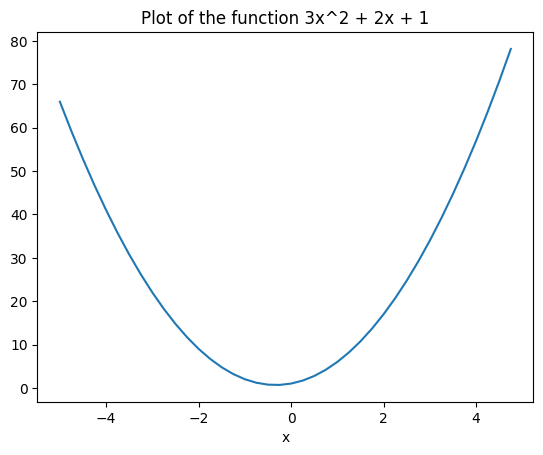

In [39]:
xs=np.arange(-5,5,0.25)
ys=f(xs)
plt.plot(xs,ys)
plt.title("Plot of the function 3x^2 + 2x + 1")
plt.xlabel("x")


In [40]:
h=0.0001
x=2.0
print(f(x)) # Evaluate f at x=2.0
dx=(f(x+h)-f(x))/h # Numerical derivative
dx
## so Basically if the function is f(x) and x value is passed it will be 20 and the derivative at that point will be 14...this is the value of function if there is slight change in x i.e x+h... 


17.0


14.000300000027721

In [41]:
a=2.0
b=-3.0
c=10.0

h=0.001
d1=a+b+c
c+=h
d2=a+b+c


print("d1",d1)
print("d2",d2)
print("derivative:",(d2-d1)/h) #The function increases at a rate of approximately 1 unit per unit increase.

d1 9.0
d2 9.001
derivative: 0.9999999999994458


### Using the correct form:

Positive value
→ A small increase in 
𝑥
x causes the function value to increase
→ The function has a positive slope at that point

Negative value
→ A small increase in 
𝑥
x causes the function value to decrease
→ The function has a negative slope at that point

self → the node (object)

self.data → the numerical value

self.grad → the numerical gradient

other → another node

other.data → that node’s numerical value

out.grad → the upstream (far) numerical gradient

In [3]:
class Value: #Autograd is forward computation plus backward backtracking through the computation graph.
    def __init__(self,data,_Children=(),_op='',label=''): # Constructor...
        self.data=data #Stores the numerical value of the node...
        self._prev=set(_Children) #_prev records the dependencies of each value, forming the backbone of the computation graph used for backpropagation.(Elements like {a,b} that made that value)
        self._backward=lambda:None # Storing the grad...
        self._op=_op # _op help us to get which operation made that value... 
        self.label=label
        self.grad=0.0
# We are maintaining a graph-like structure where two previous elements (_prev) are combined using a specific operation (_op) to create a new node whose numerical value is stored in data...

    def __repr__(self): ## Help us to repesent data in understandable form...
        return f"Value(data={self.data})"
    
    def __add__(self,other): ## Using dunder (magic) methods, we define how user-defined objects behave with built-in Python operations and operators.
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data+other.data,(self,other),'+')

        def _backward():
            self.grad+= 1.0 * out.grad # 1.0 times far gradient...
            other.grad+= 1.0 * out.grad
        out._backward=_backward
        return out # a+b #Python make it as(a.__add__(b)) 
    
    def __mul__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data*other.data,(self,other),'*')

        def _backward():
            self.grad+=other.data * out.grad #local derivative times far gradient...
            other.grad+=self.data * out.grad
        out._backward=_backward
        return out # a*b #Python make it as(a.__mul__(b))
    
    def __rmul__(self,other): #reverse mul
        return self*other
    
    def __neg__(self): ## for substraction....
        return self * -1
    
    def __sub__(self,other):
        return self+(-other)
    
    def pow(self,other): ## For power...
        assert isinstance(other,(int,float))
        out=Value(self.data**other,(self,),_op=f"**{other}")

        def _backward():
            self.grad+=other*(self.data**(other-1))*out.grad
        out._backward=_backward
        return out
    
    def tanh(self): # Tanh activation function:
        n=self.data
        tanh=(math.exp(2*n)-1)/(math.exp(2*n)+1)
        out=Value(tanh,(self,),'tanh')

        def _backward():
            self.grad+= (1-tanh**2)*out.grad #derivative of tan * far gradient...
        out._backward=_backward
        return out
    
    def exp(self):
        x=self.data
        out=Value(math.exp(x),(self,),label='exp')

        def _backward():
            self.grad+=out.data*out.grad
        out._backward=_backward
        return out
    
    def __truediv__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        return self*other.pow(-1)

    def backward(self):
        # Now instaead of manual gradient calculation we will use _backward function...
        # Topological sort for traversing the whole Derivate graph...
        topo = []
        visited = set()

        def build(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build(child)
                topo.append(v)
        build(self)

        self.grad=1.0
        for node in reversed(topo):
            node._backward()
        

#Python converts arithmetic expressions into chained dunder method calls, which lets us build a computation graph transparently.
a=Value(2.0,label='a')
b=Value(-3.0,label='b')
c=Value(10.0,label='c')
e=a*b;e.label='e'
d=e+c;d.label='d'
f=Value(-2.0,label='f')
L=f*d; L.label='L'

### Initially, each node stores only its value during the forward pass. During backpropagation, each node also stores the gradient associated with that value.

## Visualization:

In [31]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        # if this value is a result of some operation, create an op node for it
        if n._op:
            dot.node(
                name=uid + n._op,
                label=n._op
            )
            # connect this op node to the value node
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


### During backpropagation, we compute how each node in the computation graph affects the final output 
𝐿
L by calculating the partial derivative of 
𝐿
L with respect to each node.

In [7]:
#L=d*f
#dl/dd=f #Derivative of loss with repect to d...
#similarly dl/df=d #Derivative of loss with repect to f...

#dd/dc=1.0
#dd/de=1.0
########## Apply Chain Rule:
#(dl/dd)*(dd/dc)=dl/dc  # far_gradient*local_derivative
#-2*1.0=-2.0
#(dl/dd)*(dd/de)=dl/de
#-2.0*1.0=-2.0

#Now we want dl/db and dl/da
#de/da=b=-3.0
#de/db=2.0
#dl/da=(dl/de)*(de/da)
#-2.0*-3.0=6.0
#dl/db=(dl/de)*(de/db)
#-2.0*2.0=-4.0

In [75]:
L.grad=1.0
f.grad=4.0
d.grad=-2.0
c.grad=-2.0
e.grad=-2.0
a.grad=6.0
b.grad=-4.0

In [76]:
def Derivative_Checker():
    h=0.001

    a=Value(2.0,label='a')
    b=Value(-3.0,label='b')
    c=Value(10.0,label='c')
    f=Value(-2.0,label='f')
    e=a*b;e.label='e'
    d=e+c;d.label='d'
    L=f*d;L.label='L'
    L1=L.data

    a=Value(2.0,label='a')
    a.data+=h
    b=Value(-3.0,label='b')
    c=Value(10.0,label='c')
    f=Value(-2.0,label='f')
    e=a*b;e.label='e'
    d=e+c;d.label='d'
    L=f*d;L.label='L'
    L2=L.data

    print((L2-L1)/h)

Derivative_Checker()
    

6.000000000000227


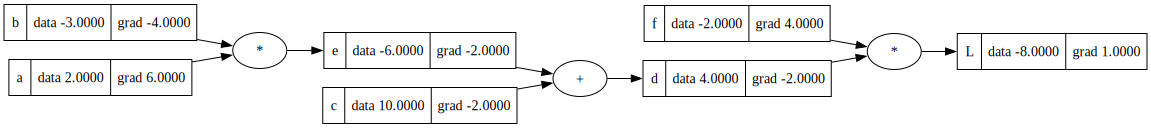

In [77]:
draw_dot(L)

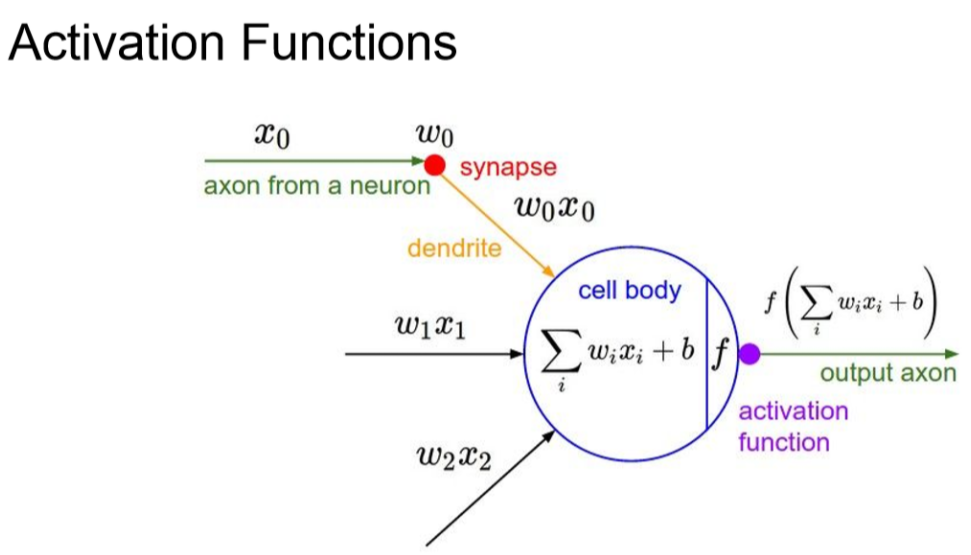

###  Bias:

**Prevents forced zero output when inputs sum to zero
**Shifts activation threshold
**Increases model expressiveness

--
Without a bias term, a neuron can become inactive at zero input and less expressive because its activation is forced to pass through the origin.

In [85]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.88, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh() ; o.label='output' 


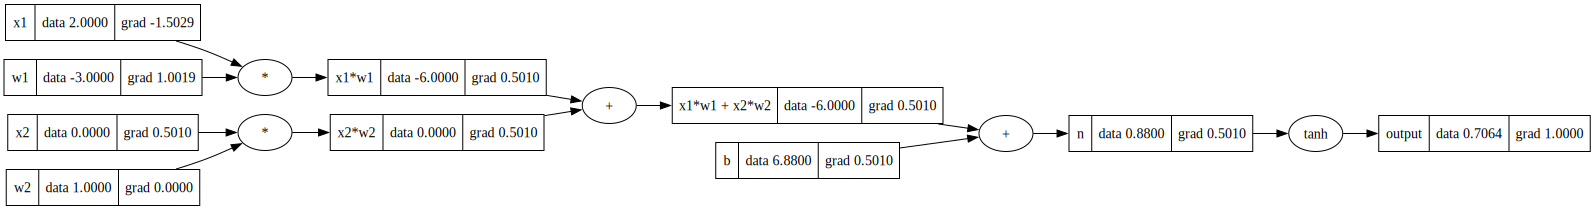

In [84]:
o.backward()
draw_dot(o)

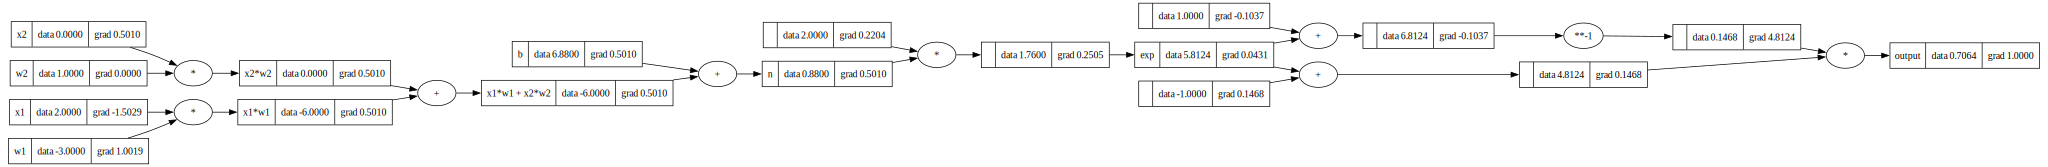

In [86]:
e= (2*n).exp()
o=(e-1)/(e+1)
o.label= 'output'
o.backward()
draw_dot(o)

In [ ]:
#Grad Calculation:
#output=1.0 (Base Case)
#n=do/dn=Derivative of tanh=1-(tanh)**2
#=1-(0.7064)**2
#b and x1w1x2w2 will have same as n as + is the distributor of gradient, similarly x1w1 and x2w2
#do/dw1=do/dx1=(do/dx1w1)*(dx1w1/dw1)
#2.0*0.5010
#simlarly for others..

In [13]:
# o.grad=1.0
# n.grad=1-((0.7064)**2)
# b.grad=0.5010
# x1w1x2w2.grad=0.5010
# x1w1.grad=0.5010
# x2w2.grad=0.5010
# w1.grad=2.0*0.5010
# x1.grad=-3.0*0.5010
# w2.grad=0.0
# x2.grad=0.5010

### Using Pytorch:

In [97]:
import torch

x1=torch.tensor([2.0]).double();x1.requires_grad=True
x2=torch.tensor([0.0]).double();x2.requires_grad=True
w1=torch.tensor([-3.0]).double();w1.requires_grad=True
w2=torch.tensor([1.0]).double();w2.requires_grad=True
b=torch.tensor([6.88]).double();b.requires_grad=True
n=x1*w1+x2*w2+b
o=torch.tanh(n)
print(o.item())
o.backward()
print(x1.grad.item())
print(w1.grad.item())
print(x2.grad.item())
print(x2.grad.item())

0.7064193777288968
-1.5029149883073543
1.0019433255382362
0.5009716627691181
0.5009716627691181


### Defining Neural Network:
A neuron has one weight per input, but only one bias shared across all inputs.

In [136]:
import random
class Neuron:
    def __init__(self,nin):
        self.w=[Value(random.uniform(-1,1))for _ in range(nin)] #nin → number of inputs to single neuron
        self.b=Value(random.uniform(-1,1))

    def __call__(self,x):
        act=sum((wi*xi for wi, xi in zip(self.w,x)),self.b)
        out=act.tanh()
        return out
    
    def parameters(self):
        return self.w+[self.b]
    
class Layer:
    def __init__(self,nin,nout):
        self.neuron=[Neuron(nin) for _ in range(nout)] #nin → number of inputs to each neuron
                                                        #nout → number of neurons in the layer

    def __call__(self,x):
        out=[n(x)for n in self.neuron]
        return out[0] if len(out)==1 else out 
    
    def parameters(self):
        return [p for neurons in self.neuron for p in neurons.parameters()]
        #First loop → iterate over neurons 
        # Second loop → iterate over that neuron’s parameters 
        # Result → a flat list of all parameters

class MLP:
    def __init__(self,nin,nout): # Multiple Layer perceptron... 
        sz=[nin]+nout
        self.layers=[Layer(sz[i],sz[i+1])for i in range(len(nout))]

    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [137]:
x=[2.0,3.0,4.0]
n=MLP(3,[4,4,1])
n(x)#This network has 3 input features, two hidden layers with 4 neurons each, and one output neuron — a 3-4-4-1 MLP with 41 trainable parameters.

Value(data=-0.8785992359201169)

In [138]:
xs=[
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys=[1.0,-1.0,-1.0,1.0] # desired targets
ypred=[n(x) for x in xs]
ypred
# #Each training example (one row of xs) is passed through the network’s randomly initialized weights and biases.
# The forward pass produces a prediction ypred.
# The loss compares ypred with the true target ys.
# Backpropagation computes gradients of the loss with respect to every weight and bias.
# An optimizer updates the parameters to reduce the loss.


[Value(data=-0.9294130678694924),
 Value(data=-0.20753366353852787),
 Value(data=-0.9646815372836649),
 Value(data=-0.9551224356161406)]

In [139]:
loss=sum(((yout-ygrod).pow(2) for ygrod,yout in zip(ys,ypred)),Value(0.0))
loss
# ys → true targets
# ypred → model predictions
# yout → predicted value
# ygrod → true value

Value(data=8.17438881294847)

### Each input feature 𝑥𝑖 is multiplied by its corresponding weight 𝑤𝑖
All weighted inputs are summed together.
A bias 𝑏 is added.
The result is passed through an activation function to produce the neuron’s output, which becomes input to the next layer.

Mathematically:
output=𝜙(∑𝑖 𝑤𝑖𝑥𝑖 + 𝑏)


#### Everything built — layers, MLP, loss, backpropagation — is just this repeated many times.

### Gradients are computed for both inputs and parameters, but only the weights and biases are updated during training.

# The gradient points in the direction of steepest increase of the loss.
# So we update weights in the opposite direction to reduce the loss.

In [ ]:
#Positive gradient → decrease the variable to reduce loss
#Negative gradient → increase the variable to reduce loss

In [140]:
for k in range(20):

    #Forward pass:
    ypred=[n(x) for x in xs]

    #Calculate the loss:
    loss=sum(((yout-ygrod).pow(2) for ygrod,yout in zip(ys,ypred)),Value(0.0))

    #optimizer zero grad:
    for p in n.parameters():
        p.grad = 0.0 #Each epoch computes a fresh gradient; accumulation is only for the chain rule, not across epochs.
    
    #loss Backword:
    loss.backward()

    #optimizer step:
    for p in n.parameters():
        p.data+=-0.03*p.grad 

    print(k,loss.data)
    

0 8.17438881294847
1 7.7799239593765535
2 7.618238790699574
3 7.4804725355362285
4 7.300716054143825
5 7.020334485834781
6 6.5334113536230145
7 5.641190942782647
8 4.195372427955205
9 2.9016133434690543
10 2.4102565990411824
11 2.111297574709215
12 1.804294374157926
13 1.4784983090638502
14 1.1562858589249894
15 0.8661218527636478
16 0.6277641772096296
17 0.44959335365955666
18 0.32825281027048325
19 0.24966952596988867


In [141]:
ypred

[Value(data=0.7385691950188605),
 Value(data=-0.7513162676649656),
 Value(data=-0.9511862942074063),
 Value(data=0.6578054886829522)]